# CGM prediction tests #
Michael Strand / Chelsea Huynh


In [1]:
import random

# ltuple mSGD functions

def ltuple_msgd(A_tilde, y, xls, maxiter, p, ell, alpha): 

    m = np.shape(A_tilde)[0]
    n = np.shape(A_tilde)[1]
    resid_err = np.zeros((maxiter))
    act_err = np.zeros((maxiter))
    xhat = np.zeros((n, 1))
    current_iter = 0
    approx_err = np.zeros((1, maxiter))
    
    # Create Matrix Q for the update function
    L_matrix = np.zeros((n,n))
    for i in range(0, n - (n % ell), ell):
        v = np.zeros((n))
        v[i:i + ell] = 1
        L_matrix = L_matrix + (np.outer(v,v))

    while current_iter < maxiter:
        
        i = random.randint(0,m-1)
        Ai_tilde = A_tilde[i,:]
        
        # split these since numpy is weird with matrix mults and we don't want any mistakes
        At = np.transpose(Ai_tilde)
        A1 = np.dot(Ai_tilde, xhat) - p*y[i]
        AA = (A1*At).reshape((n,1))
        BB = np.multiply(L_matrix, np.outer(Ai_tilde, Ai_tilde))
        CC = np.dot(BB, xhat)
        
        gxk = (1/p**2)*AA - ((1-p)/p**2)*CC
        xhat -= alpha*gxk
        
        y_e = np.linalg.norm(np.dot(A_tilde, xhat) - y)**2
        resid_err[current_iter] = y_e
        
        x_e = np.linalg.norm(xls - xhat)**2
        act_err[current_iter] = x_e
        
        current_iter += 1
            
    return resid_err, act_err

In [2]:
import random

# SGD function

def sgd(A_tilde, y, xls, maxiter, alpha): 

    m = np.shape(A_tilde)[0]
    n = np.shape(A_tilde)[1]
    resid_err = np.zeros((maxiter))
    act_err = np.zeros((maxiter))
    xhat = np.zeros((n, 1))
    current_iter = 0
    approx_err = np.zeros((1, maxiter))

    while current_iter < maxiter:
        
        i = random.randint(0,m-1)
        Ai_tilde = A_tilde[i,:]
        
        # split these since numpy is weird with matrix mults and we don't want any mistakes
        At = np.transpose(Ai_tilde)
        A1 = np.dot(Ai_tilde, xhat) - y[i]
        AA = (A1*At).reshape((n,1))
        
        gxk = AA
        xhat -= alpha*gxk
        
        y_e = np.linalg.norm(np.dot(A_tilde, xhat) - y)**2
        resid_err[current_iter] = y_e
        
        x_e = np.linalg.norm(xls - xhat)**2
        act_err[current_iter] = x_e
        
        current_iter += 1
            
    return resid_err, act_err

In [3]:
def trimCGM(files:list, day:int):
    """Takes in a list of paths to csv files. Writes the trimmed data to a folder, which we will import into MATLAB for making and L-tuple SGD.
    csv files list should be in the order of Summary, ECG, Breathing, and Glucose tables.
    Returns a list of 2 dataframes, qualities which is a joined Summary, ECG, and Breathing table in the first index and the correspoinding Glucose
    table in the second index."""

    # read in the 4 tables for Patient X on Day Y
    summary = pd.read_csv(files[0])
    ecg = pd.read_csv(files[1])
    breathing = pd.read_csv(files[2])
    glucose = pd.read_csv(files[3])



    # ----- CLEANING UP GLUCOSE TABLE -----
    # filter out all manual readings
    glucose = glucose[glucose.type != 'manual']

    # create a string for the day number you want to filter glucose table for
    date_str = f'2014-10-0{day}'

    # filter glucose table for indicated day only
    glucose = glucose[glucose.date == date_str]

    # combine the strings from date and time coulmns and turm them into datetime objects
    glucose['Time'] = glucose.date + " " + glucose.time
    glucose = glucose.loc[:, ['Time', 'glucose', 'type']]

    # convert Time column into datetime objects
    glucose['Time'] = pd.to_datetime(glucose['Time'])  

    
    
    # ----- CLEANING UP SUMMARY TABLE -----
    # drop unecessary columns
    summary = summary.drop('BRNoise', axis=1)
    summary = summary.drop('BRConfidence', axis=1)
    summary = summary.drop('GSR', axis=1)
    summary = summary.drop('LinkQuality', axis=1)
    summary = summary.drop('RSSI', axis=1)
    summary = summary.drop('TxPower', axis=1)
    summary = summary.drop('HRV', axis=1)

    # fill 0's in HR column with the previous value
    summary['HR'] = summary['HR'].mask(summary['HR'] == 0).ffill(downcast='infer')

    # convert Time column into datetime object
    summary['Time'] = summary['Time'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y %H:%M:%S.%f'))



    # ----- TRIMMING GLUCOSE AND SUMMARY TABLES -----
    # TOP TRIM
    # find time that patient woke up on Day 2 (first time recorded in summary table)
    summary_start_time = summary['Time'].iloc[0]
    
    print(day)
    print("summary_start_time:", summary_start_time)
    
    # filter glucose table to be start 5 minutes after summary_start_time
    glucose = glucose[glucose['Time'] > summary_start_time + timedelta(minutes=5)]

    # get the start time from raw_glucose_top_trim
    glucose_start_time = glucose['Time'].iloc[0]
    
    print("glucose_start_time:", glucose_start_time)
    
    # go back to summary table and cut it back 5 minutes from the start of glucose table
    summary = summary[summary['Time'] > glucose_start_time - timedelta(minutes=5)]

    # get the last time stamp in summary table - this is the time they go to sleep
    summary_end_time = summary['Time'].iloc[-1]
    
    print("summary_end_time:", summary_end_time)
    
    # now we want to filter glucose to end 5 minutes after summary_end_time
    glucose = glucose[glucose['Time'] < summary_end_time]

    # the last glucose measurement that aligns with summary data
    glucose_end_time = glucose['Time'].iloc[-1]
    print("glucose_end_time:", glucose_end_time)
    
    # trim off summary info that extends beyond the last glucose measure
    summary = summary[summary['Time'] < glucose_end_time]

    
    # save the noise column
    noise = summary['ECGNoise']  
    summary = summary.drop('ECGNoise', axis=1)

    
    
    # ----- CLEANING ECG DATA -----
    # take the millisecond string from the the first entry
    millisecond_str = ecg['Time'].iloc[0][-3:]

    # filter for only times with that milisecond string
    ecg = ecg.loc[ecg['Time'].str[-3:] == millisecond_str]

    # turn the Time coulmn into datetime objects
    ecg['Time'] = ecg['Time'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y %H:%M:%S.%f'))

    # align raw_ecg with the summary times
    new_summmary_start_time = summary['Time'].iloc[0]
    ecg = ecg[ecg['Time'] >= new_summmary_start_time]


    
    # ----- CLEANING BREATHING DATA -----
    # filter for only times with that milisecond string
    breathing = breathing.loc[breathing['Time'].str[-3:] == millisecond_str]

    # turn the Time coulmn into datetime objects
    breathing['Time'] = breathing['Time'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y %H:%M:%S.%f'))

    # align with raw_summary data
    ecg = ecg[ecg['Time'] >= new_summmary_start_time]


    qualities = pd.concat([summary.set_index('Time'),
                            ecg.set_index('Time'),
                            breathing.set_index('Time')], axis=1, join='inner')
    


    return [qualities, glucose, noise]

In [20]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# standardize, reshape, mask and then run comparison + plot according to parameters

def cgm_preds(raw_data, glucose_readings, noise, features: list, tau : int, maxiter : float, too_high_noise : float, sampling : str, metric : str):
    
    # raw_data: dataframe containing all features and raw measurements as read from csv (after trimming)
    # glucose_readings: dataframe of values to predict - this is y
    # noise: vector of noise measurement each second (for masking)
    # features: the predicting variables
    # tau: number of samples per minute we use to predict
    # maxiter: max iterations
    # too_high_noise: if noise(i) > too_high_noise, the tuple associated with time for noise(i) is masked with 0s
    # sampling: ('Random', 'Average', 'Constant') defines how rows of the raw data matrix are selected
    
    qualities_norm = raw_data.copy()
    y_glucose = pd.DataFrame(glucose_readings).to_numpy().reshape(-1,1) # correct form and shape for y vector
    qualities_norm = qualities_norm[features] # separate out desired features
    noise_vec = noise.to_numpy() # Used for the mask: len(qualities_norm) x 1 vector. Holds noise value each second
    
    glucose_measure_counts = len(glucose_readings) 
    ell = len(features) # tuple length = feature count
    m = glucose_measure_counts # number of rows    
    
    # take data in specified intervals (tau) and according to specific sampling method
    if sampling == 'Random':
        df_randsamp = pd.DataFrame()
        concat = qualities_norm.copy()
        concat['noise_ref'] = noise_vec
        
        for i in range(len(qualities_norm)//60):
            df_randsamp = df_randsamp.append(concat.iloc[60*i:60*(i+1), :].sample(tau))  
        noise_vec = df_randsamp['noise_ref']
        df_randsamp.pop('noise_ref')
        qualities_norm = df_randsamp
        
    elif sampling == 'Average':   
        df_avg = pd.DataFrame()
        concat = qualities_norm.copy()
        concat['noise_ref'] = noise_vec
        
        for i in range(len(qualities_norm)//60):
            df_avg = df_avg.append(pd.DataFrame(concat.iloc[60*i:60*(i+1), :].mean(axis=0).to_numpy().reshape((1,-1))))
        noise_vec = df_avg.pop(2).to_numpy()
        qualities_norm = df_avg
        
    elif sampling == 'Constant':
        qualities_norm = pd.DataFrame(qualities_norm).iloc[::60//tau, :].to_numpy() # choose every 60/tau'th row 
        noise_vec = pd.DataFrame(noise_vec).iloc[::60//tau, :].to_numpy()    
    else:
        return None
        
    # standardize (check for normalcy)
    scaler = StandardScaler(copy = True)
    qualities_norm = scaler.fit_transform(qualities_norm)
    y_glucose_norm = scaler.fit_transform(y_glucose)            
        
    # masking by noise
    mask = np.ones((qualities_norm.shape[0],qualities_norm.shape[1]))
    A_norm_mask = qualities_norm.copy()
    A_norm_mask_plot = qualities_norm.copy() # for heatmap tuple dist plot

    index = 0
    zeros = 0
    
    # generate mask - add in 0s if noise too high    
    for i in range(len(noise_vec)):
        if noise_vec[index] > too_high_noise:
            zeros += ell
            A_norm_mask[i, :] = 0
            A_norm_mask_plot[i, :] = -100
        index += 1

    p = 1 - zeros/(A_norm_mask.size) # estimate for probability data present
        
    # reshape (glucose readings x 5 * features * frequency = m x n)
    A_norm_mask = np.reshape(A_norm_mask, (-1)) # flatten
    A_norm_mask = np.reshape(A_norm_mask, (m,-1)) # reshape - each row corresponds to 5*60 seconds (in tau intervals) of readings
    A_norm_mask_plot = np.reshape(A_norm_mask_plot, (m, -1))
    A_unmasked = np.reshape(qualities_norm, (m,-1))
    
    # least squares
    A_pinv = np.linalg.pinv(A_norm_mask)
    xls = np.dot(A_pinv, y_glucose_norm)
    
    # Plotting
    print('p:', p)
    print('A dimension:', A_norm_mask.shape)
    print('features (tuple length):', ell)

    fig, axes = plt.subplots(2, 4, figsize=(13, 7))
    fig.tight_layout(pad = 5)

    # plot tuple distribution
    plt.subplot(2, 4, 1)   
    sns.heatmap(A_norm_mask_plot, annot=False)
    plt.title('tuple distribution')
    
    for i in range(1, 8):
        alpha = 10**(-(0.5*i + 2))

        [lrerr, laerr] = ltuple_msgd(A_norm_mask, y_glucose_norm, xls, maxiter, p, ell, alpha)
        [rerr, aerr] = sgd(A_norm_mask, y_glucose_norm, xls, maxiter, alpha)
        plt.subplot(2, 4, i+1)
        
        if metric == 'Actual':
            plt.semilogy(laerr)
            plt.semilogy(aerr, '--') 
            plt.ylabel('Actual')
        if metric == 'Residual':
            plt.semilogy(lrerr)
            plt.semilogy(rerr, '--')
            plt.ylabel('Residual')
            
        plt.title("alpha: {0:.6f}".format(alpha), loc = 'right')
    
    plt.legend(['ltuple mSGD', 'SGD'], loc = 'lower left')    
    plt.show()
    
    return [A_norm_mask, y_glucose_norm, xls]

## Patient 1 (Days 2,3,4

In [5]:
import pandas as pd
import numpy as np
import math
from datetime import datetime, timedelta

p1_files2 = ["patient1data/day2/2014_10_02-10_56_44_Summary.csv",
        "patient1data/day2/2014_10_02-10_56_44_ECG.csv",
        "patient1data/day2/2014_10_02-10_56_44_Breathing.csv",
        "patient1data/glucose.csv"]
p1_day2 = trimCGM(p1_files2, 2)

p1_files3 = ["patient1data/day3/2014_10_03-06_36_24_Summary.csv",
        "patient1data/day3/2014_10_03-06_36_24_ECG.csv",
        "patient1data/day3/2014_10_03-06_36_24_Breathing.csv",
        "patient1data/glucose.csv"]
p1_day3 = trimCGM(p1_files3, 3)

p1_files4 = ["patient1data/day4/2014_10_04-06_34_57_Summary.csv",
        "patient1data/day4/2014_10_04-06_34_57_ECG.csv",
        "patient1data/day4/2014_10_04-06_34_57_Breathing.csv",
        "patient1data/glucose.csv"]
p1_day4 = trimCGM(p1_files4, 4)

2
summary_start_time: 2014-10-02 10:56:44.420000
glucose_start_time: 2014-10-02 11:04:00
summary_end_time: 2014-10-02 21:41:03.420000
glucose_end_time: 2014-10-02 21:39:00
3
summary_start_time: 2014-10-03 06:36:24.421000
glucose_start_time: 2014-10-03 06:44:01
summary_end_time: 2014-10-03 19:19:58.421000
glucose_end_time: 2014-10-03 19:19:01
4
summary_start_time: 2014-10-04 06:34:57.423000
glucose_start_time: 2014-10-04 06:44:01
summary_end_time: 2014-10-04 13:48:00.423000
glucose_end_time: 2014-10-04 13:44:01


p: 0.8765625
A dimension: (384, 10)
features (tuple length): 2


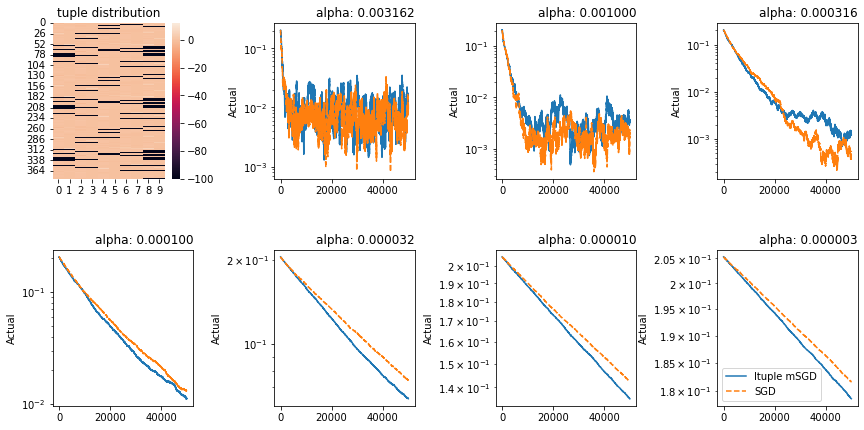

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

quals = [p1_day2[0], p1_day2[0], p1_day2[0]]
glucs = [p1_day2[1], p1_day2[1], p1_day2[1]]
noises = [p1_day2[2], p1_day2[2], p1_day2[2]]

all_qual = pd.concat(quals)
all_noise = pd.concat(noises)
all_gluc = pd.concat(glucs)

features = ['EcgWaveform', 'ECGAmplitude'] # good predictors of glucose according to paper
tau = 1
too_high_noise = 0.0008
maxiter = 50000
sampling = 'Constant'
metric = 'Actual' 

[A_norm_mask, y_glucose_norm, xls] = cgm_preds(all_qual, all_gluc['glucose'], features = features, noise = all_noise, tau = tau, 
          too_high_noise = too_high_noise, maxiter = maxiter, sampling = sampling, metric = metric)

pd.DataFrame(A_norm_mask).to_csv('A_tilde.csv', index=False)
pd.DataFrame(y_glucose_norm).to_csv('y_glucose.csv', index=False)
pd.DataFrame(xls).to_csv('xls.csv', index=False)

## Patient 7 (Days 2,3,4)

In [7]:
import pandas as pd
import numpy as np
import math
from datetime import datetime, timedelta

p7_files2 = ["patient7data/day2/2014_10_02-07_52_44_Summary.csv",
        "patient7data/day2/2014_10_02-07_52_44_ECG.csv",
        "patient7data/day2/2014_10_02-07_52_44_Breathing.csv",
        "patient7data/glucose.csv"]
p7_day2 = trimCGM(p7_files2, 2)

p7_files3 = ["patient7data/day3/2014_10_03-06_46_57_Summary.csv",
        "patient7data/day3/2014_10_03-06_46_57_ECG.csv",
        "patient7data/day3/2014_10_03-06_46_57_Breathing.csv",
        "patient7data/glucose.csv"]
p7_day3 = trimCGM(p7_files3, 3)

p7_files4 = ["patient7data/day4/2014_10_04-08_27_21_Summary.csv",
        "patient7data/day4/2014_10_04-08_27_21_ECG.csv",
        "patient7data/day4/2014_10_04-08_27_21_Breathing.csv",
        "patient7data/glucose.csv"]
p1_day4 = trimCGM(p7_files4, 4)

2
summary_start_time: 2014-10-02 07:52:44.437000
glucose_start_time: 2014-10-02 07:59:59
summary_end_time: 2014-10-02 18:45:06.437000
glucose_end_time: 2014-10-02 18:44:59
3
summary_start_time: 2014-10-03 06:46:57.440000
glucose_start_time: 2014-10-03 06:55:00
summary_end_time: 2014-10-04 02:40:47.440000
glucose_end_time: 2014-10-03 23:55:00
4
summary_start_time: 2014-10-04 08:27:21.440000
glucose_start_time: 2014-10-04 08:35:00
summary_end_time: 2014-10-04 22:09:07.440000
glucose_end_time: 2014-10-04 22:05:01


In [18]:
quals = [p7_day2[0], p7_day2[0], p7_day2[0]]
glucs = [p7_day2[1], p7_day2[1], p7_day2[1]]
noises = [p7_day2[2], p7_day2[2], p7_day2[2]]

all_qual = pd.concat(quals)
all_noise = pd.concat(noises)
all_gluc = pd.concat(glucs)

p: 0.8661538461538462
A dimension: (390, 10)
features (tuple length): 2


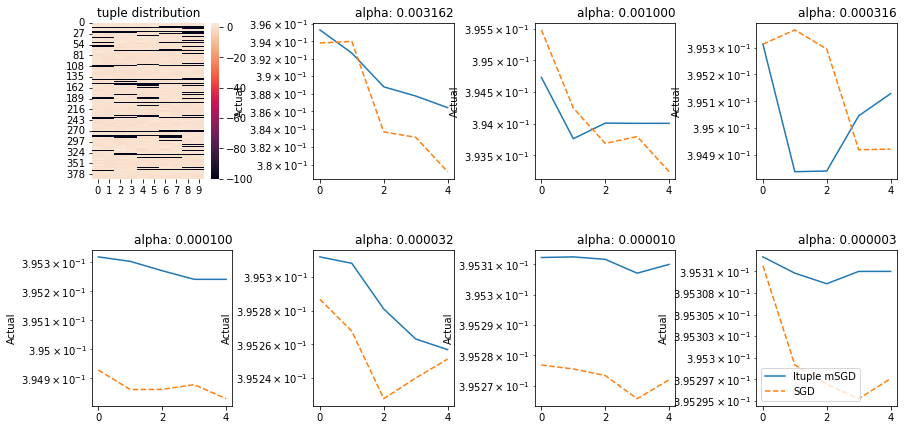

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

quals = [p7_day2[0], p7_day2[0], p7_day2[0]]
glucs = [p7_day2[1], p7_day2[1], p7_day2[1]]
noises = [p7_day2[2], p7_day2[2], p7_day2[2]]

all_qual = pd.concat(quals)
all_noise = pd.concat(noises)
all_gluc = pd.concat(glucs)

features = ['EcgWaveform', 'ECGAmplitude'] # good predictors of glucose according to paper
tau = 1
too_high_noise = 0.0009
maxiter = 5
sampling = 'Random'
metric = 'Actual' 

[A_norm_mask, y_glucose_norm, xls] = cgm_preds(all_qual, all_gluc['glucose'], features = features, noise = all_noise, tau = tau, 
          too_high_noise = too_high_noise, maxiter = maxiter, sampling = sampling, metric = metric)


pd.DataFrame(A_norm_mask).to_csv('A_tilde.csv', index=False)
pd.DataFrame(y_glucose_norm).to_csv('y_glucose.csv', index=False)
pd.DataFrame(xls).to_csv('xls.csv', index=False)